# Levy-Lieb Procedure for Variational Quantum Eigensolvers - The Hubbard Dimer

In this notebook, we will calculate the ground state of a Hubbard dimer using the Levy-Lieb procedure. First consider an interacting-particle system described by the Hamiltonian,
\begin{equation*}
\hat{H} = \hat{T} + \hat{W} + \hat{v}
\end{equation*}

where $\hat{T}$, $\hat{W}$ are the kinetic and interaction potential operators and $\hat{v}$ is the external potential operator. The Levy-Lieb procedure relies on the the Levy-Lieb density functional which is evaluated by minimizing the expectation:

\begin{equation*}
F_{LL}(t) = \langle \psi(t) | \hat{T} + \hat{W} | \psi(t) \rangle
\end{equation*}

Subject to the constraint 
\begin{equation*}
\|d\| \equiv \| \langle \Psi(t) | \hat{\mathbf{D}} | \Psi(t) \rangle\ \|  = 0
\end{equation*}

where  
\begin{equation*}
\mathbf{\hat{D}} \equiv \left[ \sum_{\sigma} \hat{c}^\dagger_{i\sigma} \hat{c}_{i\sigma} - n_i, \quad i = 1..M \right]
\end{equation*}

where $M$ is the size of the system. The value of $\mathbf{n}$ is varied to minimise $F_{LL} (\mathbf{v}) + \mathbf{v} . \mathbf{n}$ classically. At the optimum, $\mathbf{n}^{*}$, the ground state is simply
\begin{equation*}
E_{ground}( \mathbf{v}) = F_{LL} ( \mathbf{n}^{*}) + \mathbf{v} . \mathbf{n}^{*}
\end{equation*}

___________________________________________________________________________________________________________________________________________________________




The Hubbard Dimer is defined by the following Hamiltonian:
\begin{equation*}
\hat{H} = -t \sum_{\sigma=\uparrow,\downarrow} (c^\dagger_{1\sigma} c_{2\sigma} + \text{h.c.}) + U \sum_{i} \hat{n}_{i\uparrow} \hat{n}_{i\downarrow} + \sum_{i} v_i (\hat{n}_{i\uparrow} + \hat{n}_{i\downarrow})
\end{equation*}


In [2]:
import numpy as np
from qiskit_nature.second_q.operators import FermionicOp

def hubbard_dimer_ham(t, u, dv):
    """
    Calculates the hamiltonian for a symmetric hubbard dimer
    Args:
        t (float): Kinetic energy parameter
        u (float): Interaction energy parameter.
        dv (float): Onsite, symmetric, potential energy difference
    Returns:
        FermionicOp
    """
    # Define the potential energy terms for the symmetric dimer
    v1 = -dv / 2  
    v2 = dv / 2

    # Kinetic Energy, T, Interaction Energy, W
    T = -t * (FermionicOp({f"+_3 -_2" : 1}, 4) + FermionicOp({f"+_2 -_3" : 1}, 4) + 
              FermionicOp({f"+_1 -_0" : 1}, 4) + FermionicOp({f"+_0 -_1" : 1}, 4))
    W = u * (FermionicOp({f"+_3 -_3 +_1 -_1" : 1}, 4) + FermionicOp({f"+_2 -_2 +_0 -_0" : 1}, 4))

    # Onsite potential energy terms
    V1 = v1 * (FermionicOp({f"+_3 -_3" : 1}, 4) + FermionicOp({f"+_1 -_1" : 1}, 4))
    V2 = v2 * (FermionicOp({f"+_2 -_2" : 1}, 4) + FermionicOp({f"+_0 -_0" : 1}, 4))
    return (T + W + V1 + V2).simplify()


We will use the Jordan Wigner Mapping which allows us to track site occupation of each orbital. In total in our system there are 4 spin-specific orbitals. It is convention in Qiskit that these orbitals are ordered by spin. Our mapping is as follows:

\begin{array}{ccccccc}
|0000 \rangle & \Rightarrow & \text{Site 1:} & \_ & \_ & \text{Site 2:} & \_ & \_  \\
|0001 \rangle & \Rightarrow & \text{Site 1:} & \uparrow & \_ & \text{Site 2:} & \_ & \_  \\
|0010 \rangle & \Rightarrow & \text{Site 1:} & \_ & \_ & \text{Site 2:} & \uparrow & \_  \\
|0100 \rangle & \Rightarrow & \text{Site 1:} & \_ & \downarrow & \text{Site 2:} & \_ & \_ & \\
|1000 \rangle & \Rightarrow & \text{Site 1:} & \_ & \_ & \text{Site 2:} & \_ & \downarrow \\
|0011 \rangle & \Rightarrow & \text{Site 1:} & \uparrow & \_ & \text{Site 2:} & \uparrow & \_  \\
|0101 \rangle & \Rightarrow & \text{Site 1:} & \uparrow & \downarrow & \text{Site 2:} & \_ & \_ \\
\end{array}

and so on...

We will now define the number operator which has the following property:

\begin{equation*}
\hat{c}^{\dagger}_{i\sigma} \hat{c}_{i\sigma} | \psi \rangle= \hat{n}_{i\sigma} | \psi \rangle = n_{i\sigma} | \psi \rangle
\end{equation*}

where $\sigma = \uparrow, \downarrow$. Therefore, we can track site occupation of certain spins by calculating the expectation value of the number operator. We will define a function to compute the expectation value of any operator with respect to state $| \psi \rangle$ below.


In [3]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

def number(orbital):
    """
    Returns the number operator for a specified orbital
    Args:
        orbital (int): Speifies the orbital number. Orbitals are ordered by spin.
    Returns:
        SparsePauliOp
    """
    return mapper.map(FermionicOp({f"+_{orbital} -_{orbital}" : 1}, 4))

def expect(operator, state):
    """
    Calculates expectation value of input operator wrt state using inner product
    Args:
        operator (SparsePauliOp)
        state (Statevector)
    Returns:
        float
    """
    bra = np.conjugate(np.transpose(state)).data 
    ket = state.data                             
    return bra @ operator.to_matrix() @ ket  # <Ψ| operator |Ψ>


Our ansatz describes the functional form of the eigenstate we anticipate $ |\Psi(t) \rangle = U(t) \ |\Psi_{i}\rangle$.
The parameters $\mathbf{t}$ will be varied to minimize $\langle \Psi(t) | \hat{T} + \hat{W} | \Psi(t) \rangle$. (In code, the optimizer refers to the ansatz parameters as '$\mathbf{x}$'). The ansatz will use be using is the unitary coupled cluster with single and double excitations. It is in the ansatz, we describe some of the allowable conditions for our final state. i.e. the number of particles and whether or not spin is conserved. 

In [4]:
from qiskit import QuantumCircuit
from qiskit_nature.second_q.circuit.library import UCCSD

initial_state = QuantumCircuit(4)
initial_state.x([0, 3])    

# Define ansatz as UCC. Contains a series of gates of parameter t[i]. These parameters are optimised in the VQE program.
ansatz = UCCSD(num_spatial_orbitals = 2,              
               num_particles = [1, 1],                # One spin up, one spin down
               qubit_mapper = JordanWignerMapper(),   
               preserve_spin = False,                 
               reps = 2,                              
               initial_state = initial_state 
              )

print('Our ansatz is as follows:')
ansatz.decompose().draw(style = 'iqp')


Our ansatz is as follows:


┌───┐┌───────────────────────────────┐┌───────────────────────────────┐»
q_0: ┤ X ├┤0                              ├┤0                              ├»
     └───┘│                               ││                               │»
q_1: ─────┤1                              ├┤1                              ├»
          │  exp(-it (IIXY + IIYX))(t[0]) ││  exp(-it (XZZY + YZZX))(t[1]) │»
q_2: ─────┤2                              ├┤2                              ├»
     ┌───┐│                               ││                               │»
q_3: ┤ X ├┤3                              ├┤3                              ├»
     └───┘└───────────────────────────────┘└───────────────────────────────┘»
«     ┌───────────────────────────────┐┌───────────────────────────────┐»
«q_0: ┤0                              ├┤0                              ├»
«     │                               ││                               │»
«q_1: ┤1                              ├┤1                              ├»
«     │  exp(-it (IXYI + IYXI))(t[2]) ││  exp(-it (XYII + YXII))(t[3]) │»
«q_2: ┤2                              ├┤2                              ├»
«     │                               ││                               │»
«q_3: ┤3                              ├┤3                              ├»
«     └───────────────────────────────┘└───────────────────────────────┘»
«     ┌─────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                        ├»
«     │                                                                         │»
«q_1: ┤1                                                                        ├»
«     │  exp(-it (YYXY + XYYY + XXXY + YXYY + XYXX + YYYX + YXXX + XXYX))(t[4]) │»
«q_2: ┤2                                                                        ├»
«     │                                                                         │»
«q_3: ┤3                                                                        ├»
«     └─────────────────────────────────────────────────────────────────────────┘»
«     ┌───────────────────────────────┐┌───────────────────────────────┐»
«q_0: ┤0                              ├┤0                              ├»
«     │                               ││                               │»
«q_1: ┤1                              ├┤1                              ├»
«     │  exp(-it (IIXY + IIYX))(t[5]) ││  exp(-it (XZZY + YZZX))(t[6]) │»
«q_2: ┤2                              ├┤2                              ├»
«     │                               ││                               │»
«q_3: ┤3                              ├┤3                              ├»
«     └───────────────────────────────┘└───────────────────────────────┘»
«     ┌───────────────────────────────┐┌───────────────────────────────┐»
«q_0: ┤0                              ├┤0                              ├»
«     │                               ││                               │»
«q_1: ┤1                              ├┤1                              ├»
«     │  exp(-it (IXYI + IYXI))(t[7]) ││  exp(-it (XYII + YXII))(t[8]) │»
«q_2: ┤2                              ├┤2                              ├»
«     │                               ││                               │»
«q_3: ┤3                              ├┤3                              ├»
«     └───────────────────────────────┘└───────────────────────────────┘»
«     ┌─────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                        ├
«     │                                                                         │
«q_1: ┤1                                                                        ├
«     │  exp(-it (YYXY + XYYY + XXXY + YXYY + XYXX + YYYX + YXXX + XXYX))(t[9]) │
«q_2: ┤2                                                                        ├
«     │                                                           

We will also define a function 'retrieve_state' in order to obtain $|\Psi(t) \rangle$, given $t$. Using a function to retrieve parametrised state $|\Psi(t) \rangle$ from parameters, x, and calculating the expectation value as an inner product is much faster than using Qiskit's "estimate_observables()" function.

In [5]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import Statevector

# Operators within the ansatz in sequential order. Does not include repetitions.
ops = mapper.map(ansatz.excitation_ops())
reps = ansatz.reps                         


def retrieve_state(ansatz, x):
    """
    Retrieves the statevector, given the ansatz parameters, x
    Args:
        ansatz (EvolvedOperatorAnsatz)
        x (numpy.ndarrayy): Must have the same length as the ansatz.
    Returns:
        Statevector
    """
    ucc = QuantumCircuit(4)           
    ucc.x([0, 3])                   

    for i in range(reps):
        for j, op in enumerate(ops):
            ansatz_gate = PauliEvolutionGate(op, time = x[i * len(ops) + j])  # Input each value of x into each gate
            ucc.append(ansatz_gate, range(ansatz.num_qubits))                
    return Statevector.from_instruction(ucc)

The ansatz however, does not constrain the solution to the corresponding domain of allowable densities. For instance, if we wish to calculate the Levy-Lieb functional for $\mathbf{n} = [0, 2]$, then clearly the energy associated with $|\Psi(t) \rangle = |0101 \rangle  \rightsquigarrow \mathbf{n} = [2, 0]$ is not an acceptable result. To ensure our minimisation process only returns eigenstates of allowable densities, we define the density difference operator
\begin{equation*}
\mathbf{\hat{D}} \equiv [\ \hat{n}_{1\uparrow} + \hat{n}_{1\downarrow} - n_1 \hat{I}, \ \ \ \hat{n}_{2\uparrow} + \hat{n}_{2\downarrow} - n_2 \hat{I} \ ]
\end{equation*}

whose expectation value is defined by the vector:
\begin{equation*}
\mathbf{d} \equiv \langle \Psi(t) | \mathbf{\hat{D}} | \Psi(t) \rangle\
\end{equation*}

We will constrain our VQE process such that $\| \mathbf{d}\| = 0$, which ensures that the optimisation process is limited to the space of allowable densities, $\mathcal{W}^{n}_{N}$.

In [6]:
from qiskit.quantum_info import SparsePauliOp

def D(n1):
    """
    Calculates the density difference operator
    Args:
        n1 (float): first lattice site occupation
    Returns:
        list[SparsePauliOp]
    """  
    D1 = number(0) + number(2) - SparsePauliOp(["IIII"], coeffs=[n1])
    D2 = number(1) + number(3) - SparsePauliOp(["IIII"], coeffs=[2 - n1])
    return [D1.simplify(), D2.simplify()]


def abs_d(x, n1):
    """
    Calculates  ||d||: the absolute value of the expectation of D(n1)
    Args:
        x (numpy.ndarray): ansatz parameters
        n1 ( float): first lattice site occupation
    Returns:
        float
    """
    state = retrieve_state(ansatz, x)    
    d1 = np.real(expect(D(n1)[0], state))  
    d2 = np.real(expect(D(n1)[1], state))
    return np.sqrt(d1**2 + d2**2)


Now, we define the Levy-Lieb functional, $F_{LL}$ as a function of first site occupation, $n_{1}$ and interaction potential, $U$. Our sub-routine to calculate $F_{LL}$ is obtained from Ref. 1 and is as follows:

$\rightarrow$ Step 1. Accept a vector of site occupations:
\begin{equation*}
    n \equiv [n_1, n_2] \quad \text{such that}\quad
    \begin{cases}
        0 < n_i < 2, \\
        n_1 + n_2 = 2.
    \end{cases}
\end{equation*}

 - Minimise $\langle \Psi(t) | \mathbf{\hat{D}} | \Psi(t) \rangle$ using the L-BFGS-B optimisation routine. At optimum, we have $|\Psi_{i} \rangle$ which exists approximately in the subspace of allowable wavefunctions, $\mathcal{W}^{n}_{N}$.

- Then set $|\Psi_{i} \rangle$ as the initial state for our VQE process.


$\rightarrow$ Step 2. Minimise $\langle \Psi(t)| \ \hat{T} + \hat{W} \ | \Psi(t) \rangle$ using the SLSQP optimiser subject to the constraint $\| \mathbf{d} \| = 0$. In this process, the parameters of the ansatz, $|\Psi(t) \rangle = U(t) |\Psi_{i} \rangle$ are varied until an optimum is reached.
   
- The minimum eigenvalue subject to these constraints yields $F_{LL}( \mathbf{n} )$. 

A convenient shortcut to this routine is to skip Step 1 entirely and set initial guess $|\Psi_{i} \rangle$ equal to the previously obtained ground state.

In [7]:
from numpy import random
from scipy.optimize import minimize
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP


def DC_VQE(x0, U):
    """
    Performs VQE on operator, T + W, subject to density constraints
    Args:
        x0 (numpy.ndarray): initial ansatz parameters
        U (float): interaction energy parameter
    Returns:
        VQEResult
    """
    T_W = mapper.map(hubbard_dimer_ham(0.5, U, 0))

    vqe = VQE(estimator=Estimator(),
              ansatz=ansatz,
              optimizer=SLSQP(constraints=[{'type':'eq', 'fun':abs_d, 'args':(n1,)}]),
              initial_point=x0,
             )
    return vqe.compute_minimum_eigenvalue(T_W)


def FLL(n1, U):
    """
    Computes the Levy-lieb functional and Levy-lieb embedded state
    Args:
        n1 (float, 0 < n1 < 2): first lattice site occupation
        U (float): interaction energy parameter
    Returns:
        float, Statevector
    """
    global x0
    if x0 is None:
        results = []  
        states = []
        for rep in range(2):                                                     
            ## Step 1. Minimise ||d|| to find initial guess for VQE
            min_d = minimize(fun=abs_d,
                             x0=[random.uniform(-10, 10) for _ in range(10)],
                             method='L-BFGS-B',  # Optimisation method
                             args=(n1),
                            )
            x0 = min_d.x                                                                               
    
            ## Step 2. Minimise T + W  subject to constraint that ||d|| = 0 
            res = DC_VQE(x0, U)
            results.append(res.eigenvalue)
            states.append(res.optimal_point)
        x0 = states[np.argmin(results)] # Store optimal point for next time

        return min(results), retrieve_state(ansatz, x0)

    else:                                                                            
        ## Skip to Step 2. Use optimum point from previous VQE as starting guess, x0
        res = DC_VQE(x0, U)
        x0 = res.optimal_point  # Store optimal point for next time

        return res.eigenvalue, retrieve_state(ansatz, x0)

We will cycle through the different values of $U$, and compile the calculated $F_{LL}$ and $\Psi_{LL}$ for each value of $\mathbf{n}$.

In [8]:
U_array = [0, 0.2, 1, 2, 5, 10]
n_array = np.round(np.linspace(0, 1, 101), 2)
nit = len(U_array) * len(n_array)
fll = []
states = []

for U in U_array:
    fll_U = []
    states_U = []
    x0 = None
    for n1 in n_array:
        fll_U.append(FLL(n1, U)[0])
        states_U.append(FLL(n1, U)[1])
    fll.append(fll_U)
    states.append(states_U)
        

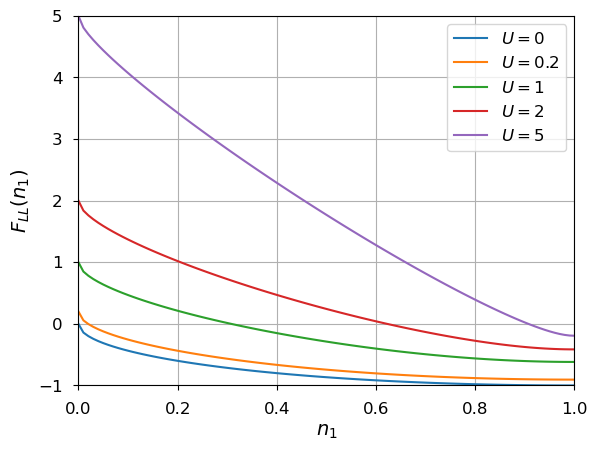

In [10]:
import matplotlib.pylab as plt

plt.xlim(0, 1)
plt.ylim(-1, 5)
plt.xlabel('$n_{1}$', fontdict={'fontsize': 14})
plt.ylabel('$F_{LL}(n_{1})$', fontdict={'fontsize': 14})
plt.grid(True)
for i in range(len(U_array) - 1):
    plt.plot(n_array, fll[i], label=f'$U = {U_array[i]}$')
plt.tick_params(axis='both', labelsize=12,  direction='out', pad=8)
plt.rcParams['font.family'] = 'Calibri'
plt.legend(prop={'size': 12})


Due to the symmetry of the lattice, the Levy-Lieb functional is symmetrical about $n_{1}$ = 1. To expand our data to $1 < n_{1} < 2$, we can take the mirror image of our obtained dataset. Furthermore, for the sake of time, let's just interpolate the dataset and call the interpolated values when calling $F_{LL}(\mathbf{n})$ in future.

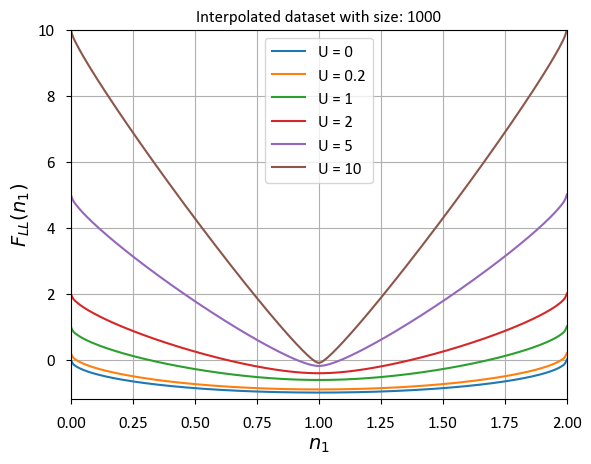

In [11]:
from scipy.interpolate import interp1d

# We want to extrapolate the data beyond n = 1 by taking the mirror image.
n_mirrored = n_array.copy()
for i in reversed(range(len(n_array[:-1]))):
    n_mirrored = np.append(n_mirrored, 2 - n_array[i])

# The mirrored Levy-Lieb functional data
fll_mirrored = []
for row in fll:
    fll_mirrored.append(row[:])
    fll_mirrored[-1].extend(reversed(row[:-1]))


def FLL_interp(n1, U):
    """
    Interpolates the mirrored Levy-lieb dataset generated by density constrained VQE.
    Args:
        n1 (float, 0 < n1 < 2): first lattice site occupation
        U ([0, 0.2, 1, 2, 5, 10]): interaction energy parameter
    Returns:
        float
    """
    u_index = U_array.index(U) # Access index of fll dataset
    f = interp1d(n_mirrored, fll_mirrored[u_index],
                axis=-1, kind='cubic', fill_value='extrapolate')
    return f(n1)

# Plot the new interpolated dataset
plt.title('Interpolated dataset with size: 1000')
plt.xlim(0, 2)
plt.ylim(-1.2, 10)
plt.xlabel('$n_{1}$', fontdict={'fontsize': 14})
plt.ylabel('$F_{LL}(n_{1})$', fontdict={'fontsize': 14})
plt.grid(True)
for i in range(len(U_array)):
    plt.plot(np.linspace(0, 2, 1000), FLL_interp(np.linspace(0, 2, 1000), U_array[i]), label=f"U = {U_array[i]}")
plt.tick_params(axis='both', labelsize=12,  direction='out', pad=8)
plt.rcParams['font.family'] = 'Calibri'
plt.legend(prop={'size': 12})


We now optimize $F_{LL}(\mathbf{n}) + \mathbf{v} \cdot \mathbf{n}$ subject to the constraint that $0 < n_{i} ≤ 2$ and $\sum_{i} n_{i} = 2$. 

In [12]:
def energy(n1, U, dv):
    """
    Calculates the expression, FLL(n) + v.n for a symmetric Hubbard dimer.
    Args:
        n1 (float, 0 < n1 < 2): first lattice site occupation
        U ([0, 0.2, 1, 2, 5, 10]): interaction energy parameter
        dv (float): onsite, symmetric potential snergy difference
    Returns:
        float
    """
    #  Consider the symmetric dimer
    v1 = -dv / 2
    v2 = dv / 2
    return FLL_interp(n1, U) + n1 * v1  + (2 - n1) * v2


def E_ground(U, dv):
    """
    Calculates the energy of the ground state by minimising the energy function wrt density, n1 using an SLSQP optimiser.
    Args:
        U ([0, 0.2, 1, 2, 5, 10]): interaction energy parameter
        dv (float): onsite, symmetric potential energy difference
    Returns:
        float
    """
    ## Step 1 - Find initial density guess for minimisation routine
    n_guess = 0                           
    E_guess = energy(n_guess, U, dv)

    # Briefly cycle through 13 values of n, compute energy and set initial guess at minimum
    for n1 in np.linspace(0.14, 2, 13):   
        E_n1 = energy(n1, U, dv)        
        if E_n1 < E_guess:
            E_guess = E_n1               
            n_guess = n1                 

    ## Step 2 - Minimise Energy function to find ground state 
    constraints = [{'type': 'ineq', 'fun': lambda x : 2 - x},  
                  {'type': 'ineq', 'fun': lambda x : x}]      

    min_E = minimize(fun = energy,                            
                     x0 = n_guess,                             
                     args = (U, dv),
                     constraints = constraints,                
                     method = 'SLSQP', 
                      )
    return min_E.fun

In [13]:
# Calculate the ground energy for 40 values of dv, for each value of U
dv_array = np.linspace(0, 20, 40)
E = []

for i in range(1, len(U_array)):
    E_list = []
    for dv in dv_array:
        E_g = E_ground(U_array[i], dv)
        E_list.append(E_g)
    E.append(E_list)

We will compare our results to that of the exact ground state. This can be calculated by calculating the eigenvalues of the matrix representation of the Hamiltonian in the basis set, $|1 ↑ 1 ↓ \rangle$, $|1 ↑ 2 ↓ \rangle$, $|1 ↓ 2 ↑ \rangle$, $|2 ↑ 2 ↓ \rangle$ [2]:

\begin{equation}
\hat{H} = \begin{bmatrix}
    2v_1 + U & -t & t & 0 \\
    -t & 0 & 0 & -t \\
    t & 0 & 0 & t \\
    0 & -t & t & 2v_2 + U
\end{bmatrix}
\end{equation}


In [14]:
def exact_E_ground(t, U, dv):
    """
    Calculates the exact eigenvalues of the symmetric dimer.
    Args:
        t (float): tunnelling amplitude
        U (float): interaction energy parameter
        dv (float): symmetric potential energy difference
    Returns:
        float
    """
    # The Hamiltonian for a symmetric dimer. 
    v1 = -dv/2
    v2 = dv/2
    H = np.array([[2 * v1 + U, -t,       t,  0],
                  [-t,          0,       0, -t],
                  [t,           0,       0,  t],
                  [0,          -t,       t,  2 * v2 + U]])    
    
    eigenvalues = np.real(np.linalg.eig(H)[0]) 
    return min(eigenvalues)

dv_array2 = np.linspace(0, 20, 3 * len(dv_array)) 
exact_E_arrays = []

for i in range(1, len(U_array)):    
    list = []
    for dv in dv_array2:
        list.append(exact_E_ground(0.5, U_array[i], dv))

    exact_E_arrays.append(list)

By calculating the exact ground state solutions, we will calculate the relative absolute error.

In [15]:
# Take the difference between exact Energy calculations and dataset to calculate relative absolute error
Errors = []
for i in range(len(exact_E_arrays)):
    error_list = []
    for j in range(len(E[0])):
        error_list.append(abs( (exact_E_arrays[i][j*3] - E[i][j])/ exact_E_arrays[i][j*3] ))
    Errors.append(error_list)

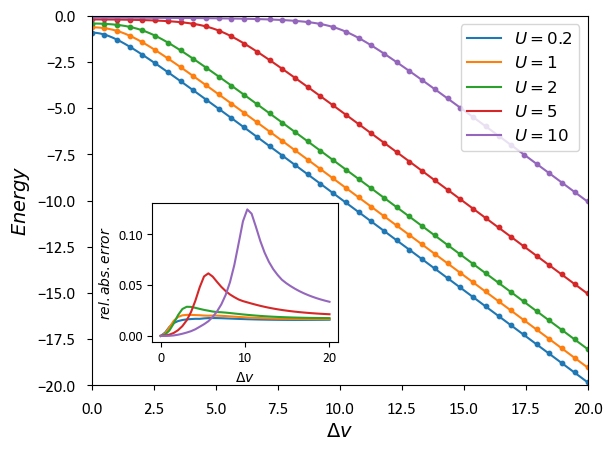

In [16]:
fig, ax_main = plt.subplots()
for i in range(len(E)):
    ax_main.scatter(dv_array, E[i], s = 10)
    ax_main.plot(dv_array2, exact_E_arrays[i], label = f'$U = {U_array[i + 1]}$')
plt.legend(loc = 1, prop = {'size':12})
plt.tick_params(axis='both', labelsize=12,  direction='out', pad=8)
left, bottom, width, height = 0.22, 0.2, 0.29, 0.29
ax_small = fig.add_axes([left, bottom, width, height])
for i in range(len(Errors)):
    ax_small.plot(dv_array, Errors[i])
ax_small.set_xlabel(r'$\Delta v$')
ax_small.set_ylabel(r'$rel. abs. error$')
ax_main.set_xlim(0, 20)
ax_main.set_ylim(-20, 0)
ax_main.set_xlabel(r'$\Delta v$',  fontdict={'fontsize': 14})
ax_main.set_ylabel(r'$Energy$',  fontdict={'fontsize': 14})
plt.show()

The relatively high error is likely due to our choice to interpolate the data as opposed to directly calling the Levy-lieb functional function in the energy minimisation process

-------------------------------------------------------------------------------------------------------------------------------------------------

Now, we will define the Levy-Lieb quantum kernel:
\begin{equation*}
\kappa_{LL}(n_1, n_2) = || \ \langle \Psi_{LL}[n_1] \ | \ \Psi_{LL}[n_2] \rangle \ || ^{2}
\end{equation*}

We will define a function which calculates the Levy-lieb kernel matrix of two pairwise datasets by accessing the appropriate index of our lists of states, $\Psi [n]$ and calculating the inner product. We will also define a function which generates the Gaussian kernel as a matrix.

In [114]:
def kernel_LL(n_array1, n_array2, U):
    """
    Calculates the Levy-Lieb kernel matrix from pairwise density density datasets, 
    for a particular value of U. 
    Calculates kernel entries by accessing appropriate indices of 'states' dataset.
    Args:
        n_array1, n_array2 (numpy.ndarray): pairwise density datasets
        U ([0, 0.2, 1, 2, 5, 10]): interaction energy parameter
    Returns:
        numpy.ndarray[numpy.ndarray]
    """
    U_index = U_array.index(U)
    K = np.zeros((len(n_array1), len(n_array2)))
    
    for i in range(len(n_array1)):
        for j in range(len(n_array2)):
            state1 = states[U_index][np.where(n_array == n_array1[i])[0][0]]       
            state2 = states[U_index][np.where(n_array == n_array2[j])[0][0]]       

            bra = np.conjugate(np.transpose(state1)).data
            ket = state2.data
            K[i][j] = np.abs(bra @ ket) ** 2
    return K


We will define a function which performs a training task given a specified training set from dataset $\Psi^{(U)}_{LL}$, using the Levy-Lieb kernel or the Gaussian kernel which is as follows:

\begin{equation*}
\kappa_G(n_1, n_2) = \frac{1}{2\sigma^2}\exp(-||n_1 - n_2||^2)
\end{equation*}

In [115]:
def kernel_G(n_array1, n_array2, sigma):
    """
    Calculates the Gaussian kernel matrix from pariwise density datasets, n_array1, n_array2
    Args:
        n_array1, n_array2 (numpy.ndarray): pairwise density datasets
        sigma: Gaussian kernel hyperparameter
    Returns
        numpy.ndarray[numpy.ndarray]
    """
    K = np.zeros((len(n_array1), len(n_array2)))
    for i in range(len(n_array1)):
        for j in range(len(n_array2)):
            K[i][j] = 1/2*sigma**2 * np.exp(-abs(n_array1[i] - n_array2[j])**2)
    return K
    

We can optimize our choice for $\sigma$ by maximising the kernel alignment defined by:
\begin{equation*}
A(K_{LL}, K_{G}) = \frac{tr(K_{LL} K_{G})}{tr(K_{LL}^2) \ tr(K_{GG}^2)}
\end{equation*}


In [130]:
def neg_alignment_LL_GG(sigma, U, n_array):
    """
    Calculates the negative Kernel alignment between the Gaussian & Levy-Lieb matrices
    Args:
        sigma (float): Gaussian hyperparameter
        U (float): interaction energy parameter
        n_array (numpy.ndarray): density dataset on which to calculate kernel matrices
    Returns:
        float
    """
    K1 = kernel_LL(n_array, n_array, U)
    K2 = kernel_G(n_array, n_array, sigma)
    return -np.trace(K1  @ K2) / (np.sqrt(np.trace(K1@K1) * np.trace(K2@K2)))


def sigma(n_array, U):
    """
    Calculates the optimum choice for Gaussian hyperparameter for training set and U
    by maximising the kernel alignment between the Levy-Lieb & Gaussian kernels.
    Args:
        n_array: Density data to compute the Kernels
        U: interaction energy parameter
    """
    sigma_opt = minimize(fun=alignment_LL_GG, method='SLSQP', args=(U, n_array), x0=1)
    return sigma_opt.fun


The learning task is performed using Kernel Ridge Regression using sklearn.

\begin{equation*}
F_{LL}[n] = \sum^{M}_{m = 1} \alpha_{m} \kappa(n_m, n)
\end{equation*}

where $n_{m}$ is the training set, and the coefficients, $\alpha_m$ are optimised my minimising:


Below, we define a function which performs kernel ridge regression using either the Levy-Lieb or Gaussian kernels. The training points are sampled evenly from our Levy-Lieb dataset within some pre-defined training bounds. The function outputs the training dataset, the model's predictions for the test dataset, the absolute difference between the test and the predicted dataset, and the root mean square error.

In [131]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import root_mean_squared_error


def learning_task(training_bounds, num_training_points, alpha, U, kernel = 'Levylieb'):
    """
    Performs Kernel ridge regression using defined training-set sampled regularly from some defined bounds of the FLL dataset
    Args:
        training_bounds (list): Range to sample training set
        num_training_points (int): Size of training set
        alpha (float): Kernel ridge regression regularisation hyperparameter
        U ([0, 0.2, 1, 2, 5, 10]): Interaction energy parameter
        kernel (['Gaussian', 'Levylieb']): Determines the whether to use levy-lieb kernel matrix or Gaussian kernel
    Returns:
        [n_train, fll_train] (numpy.ndarray, numpy.ndarray): Training dataset
        [n_test, fll_pred] (numpy.ndarray, numpy.ndarray): Predicted dataset
        [n_test, abs_error] (numpy.ndarray, numpy.ndarray): Dataset of absolute differences between prediction values and actual.
        RMSE (float): Root mean square error of predictions
    """
    # Access appropriate index
    u_index = U_array.index(U)
    
    # Test train split
    n_train = np.round(np.linspace(training_bounds[0], training_bounds[1], num_training_points), 2)
    n_test = np.array([n for n in n_array if n not in n_train])
    fll_train = np.array([fll[u_index][i] for i in range(len(n_array)) if n_array[i] in n_train]).reshape(-1, 1)
    fll_test = np.array([fll[u_index][i] for i in range(len(n_array)) if n_array[i] in n_test]).reshape(-1, 1)

    if kernel == 'Levylieb':
        # Define testing & training kernels
        K_train = kernel_LL(n_train, n_train, U)
        K_test = kernel_LL(n_test, n_train, U)
    
        # Create Kernel ridge model with regularisation hyperparameter, 4e-15
        model = KernelRidge(alpha=alpha, kernel='precomputed')
    
        # Fit model & obtain predictions
        model.fit(K_train, fll_train)
        fll_pred = model.predict(K_test)

        # Obtain absolute difference between predicted and test set
        abs_error = np.array([abs(fll_test[i] - fll_pred[i]) for i in range(len(fll_pred))])

        # Root mean square Error
        RMSE = root_mean_squared_error(fll_test, fll_pred)

        return [n_train, fll_train], [n_test, fll_pred], [n_test, abs_error], RMSE

    elif kernel == 'Gaussian':

        # Calculate the optimum Gaussian hyperparameter
        sigma_opt = sigma(n_train, U)
        
        # Define testing & training kernels
        K_train = kernel_G(n_train, n_train, sigma=sigma_opt)
        K_test = kernel_G(n_test, n_train, sigma=sigma_opt)
        
        # Create Kernel ridge model with regularisation hyperparameter, 4e-15
        model = KernelRidge(alpha=alpha, kernel='precomputed')

        # Fit model & obtain predictions
        model.fit(K_train, fll_train)
        fll_pred = model.predict(K_test)

        # Obtain absolute difference between predicted and test set
        abs_error = np.array([abs(fll_test[i] - fll_pred[i]) for i in range(len(fll_pred))]) 

        # Root mean square Error
        RMSE = root_mean_squared_error(fll_test, fll_pred)

        return [n_train, fll_train], [n_test, fll_pred], [n_test, abs_error], RMSE

First, we will perform an in-distribution learning task (L1) using our Levy-lieb kernel, wherein our training set is sampled evenly throughout the total dataset. We will plot the error by calculating the absolute difference between the predicted dataset and the values calculated by our $F_{LL}$ function. 

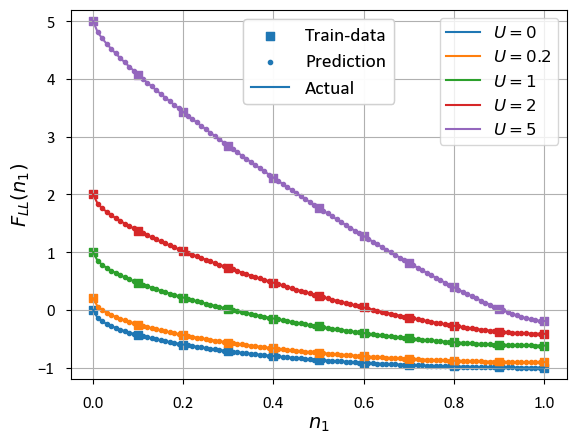

In [132]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
plt.xlim(-0.05, 1.05)
plt.ylim(-1.2, 5.2)
plt.xlabel('$n_{1}$', fontdict={'fontsize': 14})
plt.ylabel('$F_{LL}(n_{1})$', fontdict={'fontsize': 14})
plt.grid(True)
plt.tick_params(axis='both', labelsize=12,  direction='out', pad=8)
plt.rcParams['font.family'] = 'Calibri'

for i in range(len(U_array) - 1):

    L1 = learning_task([0, 1], 11, 4e-15, U_array[i])
    n_train, fll_train = L1[0]
    n_test, fll_pred = L1[1]
 
    plt.scatter(n_train, fll_train, marker='s', color=colours[i])    
    plt.scatter(n_test, fll_pred, marker='.', color=colours[i])
    plt.plot(n_array, fll[i], label=f'$U = {U_array[i]}$', color=colours[i])
    
legend1 = plt.legend(loc='upper right', prop = {'size':12})  
legend2 = plt.legend(['Train-data', 'Prediction', 'Actual'], loc=9, prop={'size':14}, labelcolor='black') 
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)


We will plot the absolute error of our learning task with respect to $n_{1}$. 

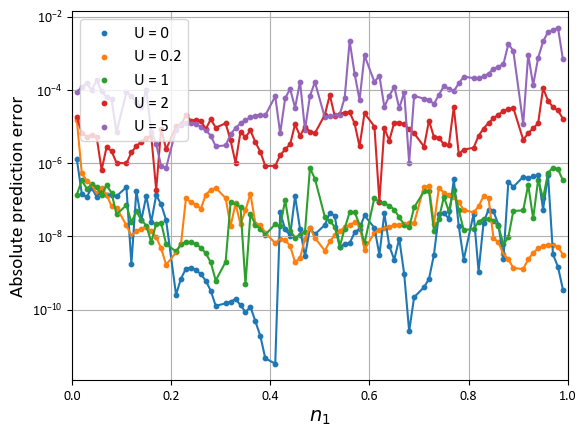

In [133]:
# Calculate the absolute prediction error for each value of U
for i in range(len(U_array) - 1):
    L1 = learning_task([0, 1], 11, 4e-15, U_array[i])
    n_test, abs_error = L1[2]

    plt.scatter(n_test, abs_error, s=10, label=f'U = {U_array[i]}')
    plt.plot(n_test, abs_error)

plt.ylabel('Absolute prediction error',  fontdict={'fontsize': 14})
plt.xlabel('$n_{1}$',  fontdict={'fontsize': 14})
plt.yscale("log")
plt.legend(loc=2, prop={'size':12})
plt.xlim(0, 1)
plt.grid(True)

We will investigate the relationship between the number of training points on the root mean square error. We will compare the results generated by the Levy-Lieb kernel to the results generated by the Gaussian kernel.

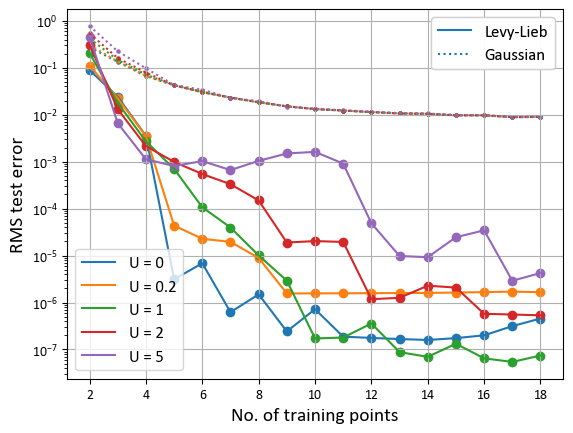

In [134]:
RMSE_list_LL = []
RMSE_list_G = []

for U in U_array:
    rmse_LL = []
    rmse_G = []
    for num_training_points in  range(2, 19):
        L1_LL = learning_task([0, 1], num_training_points, 4e-15, U)
        L1_G = learning_task([0, 1], num_training_points, 4e-15, U, kernel='Gaussian')

        rmse_LL.append(L1_LL[3])
        rmse_G.append(L1_G[3])
        
    RMSE_list_LL.append(rmse_LL)
    RMSE_list_G.append(rmse_G)


# Plot Root mean square error calculated using Levy-lieb & Gaussian kernels
for i in range(len(U_array) - 1):
    plt.plot(range(2, 19), RMSE_list_LL[i], label=f'U = {U_array[i]}', color=colours[i])
    plt.plot(range(2, 19), RMSE_list_G[i], linestyle='dotted')

    plt.scatter(range(2, 19), RMSE_list_G[i], color=colours[i], s=5)
    plt.scatter(range(2, 19), RMSE_list_LL[i], color=colours[i])
    
plt.xlabel('No. of training points', fontdict={'fontsize': 14})
plt.ylabel('RMS test error', fontdict={'fontsize': 14})
plt.yscale("log")
plt.grid('True')
legend1 = plt.legend(prop={'size':12})
legend2 = plt.legend(['Levy-Lieb', 'Gaussian'], prop={'size':12})
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

As can be seen above, the training curve for the Gaussian kernel was found to converge to $10^{-2}$, while the RMSE for the Levy-lieb kernel could reach $10^{-7}$. 

Now we will perform an out-distribution learning task (L2), where our training set will be evenly sampled $0.5 \leq n_1 \leq 1$ only.

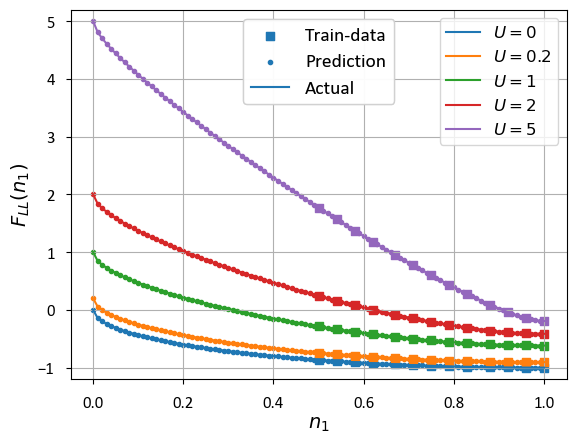

In [135]:
for i in range(len(U_array) - 1):
    # Perform extrapolative learning task
    L2 = learning_task([0.5, 1], 13, 2e-14, U_array[i])
    n_train, fll_train = L2[0]
    n_test, fll_pred = L2[1]
 
    plt.scatter(n_train, fll_train, marker='s', color=colours[i])    
    plt.scatter(n_test, fll_pred, marker='.', color=colours[i])
    plt.plot(n_array, fll[i], label=f'$U = {U_array[i]}$', color=colours[i])

plt.xlim(-0.05, 1.05)
plt.ylim(-1.2, 5.2)
plt.xlabel('$n_{1}$', fontdict={'fontsize': 14})
plt.ylabel('$F_{LL}(n_{1})$', fontdict={'fontsize': 14})
plt.grid(True)
plt.tick_params(axis='both', labelsize=12,  direction='out', pad=8)
plt.rcParams['font.family'] = 'Calibri'
legend1 = plt.legend(loc='upper right', prop = {'size':12})  
legend2 = plt.legend(['Train-data', 'Prediction', 'Actual'], loc=9, prop={'size':14}, labelcolor='black') 
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

The corresponding absolute error with respect to $n_1$ is plotted below. We can see that the error is found to increase dramatically beyond the training zone, $0.5 \leq n_{1} \leq 1$.

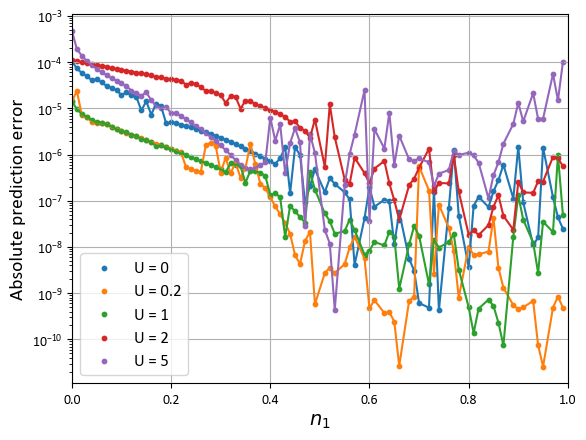

In [137]:
for i in range(len(U_array) - 1):
    L2 = learning_task([0.5, 1], 13, 4e-15, U_array[i])
    n_test, abs_error = L2[2]
    
    plt.scatter(n_test, abs_error, s=10, label=f'U = {U_array[i]}')
    plt.plot(n_test, abs_error)
plt.ylabel('Absolute prediction error',  fontdict={'fontsize': 14})
plt.xlabel('$n_{1}$',  fontdict={'fontsize': 14})
plt.yscale("log")
plt.legend(loc='best', prop={'size':12})
plt.xlim(0, 1)
plt.grid(True)

Now we will calculate the training curve for data generated by the Gaussian and Levy-Lieb kernels

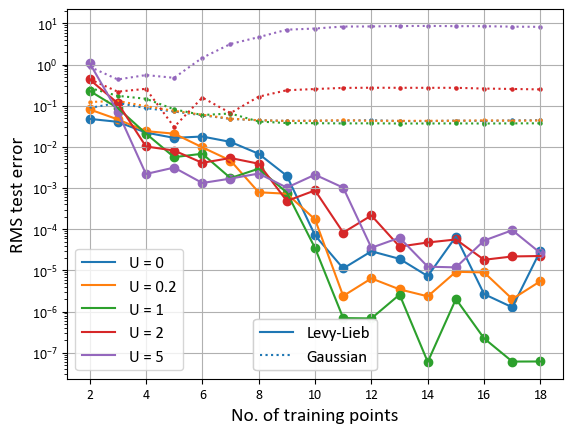

In [138]:
RMSE_list_LL = []
RMSE_list_G = []

for U in U_array:
    rmse_LL = []
    rmse_G = []
    for num_training_points in  range(2, 19):
        L1_LL = learning_task([0.5, 1], num_training_points, 4e-15, U)
        L1_G = learning_task([0.5, 1], num_training_points, 4e-15, U, kernel='Gaussian')

        rmse_LL.append(L1_LL[3])
        rmse_G.append(L1_G[3])
        
    RMSE_list_LL.append(rmse_LL)
    RMSE_list_G.append(rmse_G)


# Plot Root mean square error calculated using Levy-lieb & Gaussian kernels
for i in range(len(U_array) - 1):
    plt.plot(range(2, 19), RMSE_list_LL[i], label=f'U = {U_array[i]}', color=colours[i])
    plt.plot(range(2, 19), RMSE_list_G[i], linestyle='dotted')

    plt.scatter(range(2, 19), RMSE_list_G[i], color=colours[i], s=5)
    plt.scatter(range(2, 19), RMSE_list_LL[i], color=colours[i])

    
plt.xlabel('No. of training points', fontdict={'fontsize': 14})
plt.ylabel('RMS test error', fontdict={'fontsize': 14})
plt.yscale("log")
plt.grid('True')
legend1 = plt.legend(prop={'size':12})
legend2 = plt.legend(['Levy-Lieb', 'Gaussian'], prop={'size':12}, loc=8)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

As could be seen before for the L1 learning task, the test error of the predicted dataset trained with the Levy-Lieb kernel was found converge to a value significantly lower than that of the Gaussian kernel.

These results suggest that if we have access to the Levy-Lieb kernel, but not $\Psi^{(U)}_{LL}$, we can accurately obtain the value of the Levy-Lieb functional using kernel ridge regression.

-------------------------------------------------------------------------------------------------------------------------------------------------------

## References
1. C. D. Pemmaraju and A. Deshmukh, “Levy-lieb embedding of density-functional theory and its quantum kernel: Illustration for the hubbard dimer using near-term quantum algorithms,” Physical Review A, vol. 106, no. 4, 2022. doi:10.1103/physreva.106.042807.

2. D. J. Carrascal, J. Ferrer, J. C. Smith, and K. Burke, “The Hubbard Dimer: A density functional case study of a many-body problem,” Journal of Physics: Condensed Matter, vol. 27, no. 39, p. 393001, Sep. 2015. doi:10.1088/0953-8984/27/39/393001 